In [2]:
# 원본 코드 확인용
from torchvision import models
models.resnet

<module 'torchvision.models.resnet' from '/data/home/kseorang/.pyenv/versions/3.8.10/lib/python3.8/site-packages/torchvision/models/resnet.py'>

In [3]:
#train, test 함수 사용하기 위해 경로 추가
import sys
sys.path.append('/data/home/kseorang/Deep-Learning-Study')

import torch
from torchvision import transforms, datasets
import torch.nn as nn

from model import Model 
from TrainnTest import train, test

# 이미지 확인
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.0.1+cu117  Device: cuda


In [17]:
BATCH_SIZE = 32
EPOCHS = 100

train_dataset = datasets.CIFAR10(root = "./data/",
                                 train = True,
                                 download = True,
                                 transform = transforms.Compose([
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomChoice([
                                         transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                                         transforms.RandomAffine(
                                             degrees=15, translate=(0.2, 0.2),
                                             scale=(0.8, 1.2), shear=15)]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet 데이터셋의 통계치
                                      ]))

test_dataset = datasets.CIFAR10(root = "./data/",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    ]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

print(train_loader.dataset)
print(test_loader.dataset)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomChoice(
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
               RandomAffine(degrees=[-15.0, 15.0], translate=(0.2, 0.2), scale=(0.8, 1.2), shear=[-15.0, 15.0])
           )(p=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [42279 40266 20853 44868]


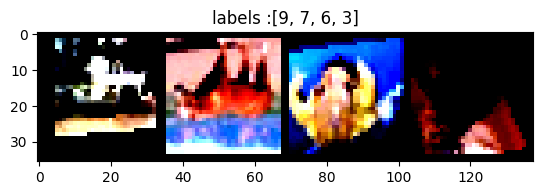

In [5]:
# 이미지 확인용
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels :' + str(y))

grid_size = 4
rnd_inds = np.random.randint(0, len(train_dataset), grid_size)
print('image indices:',rnd_inds)

x_grid = [train_dataset[i][0] for i in rnd_inds]
y_grid = [train_dataset[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)

show(x_grid, y_grid)

In [8]:
model = Model().resnet18().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum=0.9, weight_decay=0.0001)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)
criterion = nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_siz

In [7]:
train_acc_list = []
train_loss_list = []

test_acc_list = []
test_loss_list = []

for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, optimizer, DEVICE, criterion, epoch, BATCH_SIZE)
    train_acc_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    print("[EPOCH: {}] \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.4f}".format(
        epoch, train_loss, train_accuracy))

    test_loss, test_accuracy = test(model, test_loader, DEVICE, criterion, BATCH_SIZE)
    scheduler.step(metrics=test_loss)  
    test_acc_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    print("[EPOCH: {}] \tTest Loss: {:.4f}, \tTest Accuracy: {:.4f}\n".format(
        epoch, test_loss, test_accuracy))
    # 에폭당 학습률 확인(필요시)
    # l_r = [x["lr"] for x in optimizer.param_groups]
    # print("lr:{}\n".format(l_r))

[EPOCH: 1] 	Train Loss: 2.2643, 	Train Accuracy: 0.1915
[EPOCH: 1] 	Test Loss: 1.8869, 	Test Accuracy: 0.2691

[EPOCH: 2] 	Train Loss: 1.8812, 	Train Accuracy: 0.2830
[EPOCH: 2] 	Test Loss: 1.7437, 	Test Accuracy: 0.3666

[EPOCH: 3] 	Train Loss: 1.7764, 	Train Accuracy: 0.3315
[EPOCH: 3] 	Test Loss: 1.5334, 	Test Accuracy: 0.4162

[EPOCH: 4] 	Train Loss: 1.6955, 	Train Accuracy: 0.3697
[EPOCH: 4] 	Test Loss: 1.5693, 	Test Accuracy: 0.4179

[EPOCH: 5] 	Train Loss: 1.6477, 	Train Accuracy: 0.3944
[EPOCH: 5] 	Test Loss: 1.4056, 	Test Accuracy: 0.4856

[EPOCH: 6] 	Train Loss: 1.5583, 	Train Accuracy: 0.4321
[EPOCH: 6] 	Test Loss: 1.4822, 	Test Accuracy: 0.4690

[EPOCH: 7] 	Train Loss: 1.4995, 	Train Accuracy: 0.4610
[EPOCH: 7] 	Test Loss: 1.2956, 	Test Accuracy: 0.5284

[EPOCH: 8] 	Train Loss: 1.4521, 	Train Accuracy: 0.4801
[EPOCH: 8] 	Test Loss: 1.2287, 	Test Accuracy: 0.5473

[EPOCH: 9] 	Train Loss: 1.4120, 	Train Accuracy: 0.4990
[EPOCH: 9] 	Test Loss: 1.1807, 	Test Accuracy: 0.5814

[

In [1]:
# 그래프 그리기
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

x = np.arange(len(test_acc_list))

fig, ax1 = plt.subplots()
ax1.plot(x, test_acc_list, label='test_acc', color='blue')
ax1.set_ylabel('acc')
ax2 = ax1.twinx()
ax2.plot(x, test_loss_list, label='test_loss', color='red')
ax2.set_ylabel('loss')
ax1.set_xlabel("epochs")

ax1.set_title('resnet18-epoch 100')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc="upper left")

max_test_acc = max(test_acc_list)
print(max_test_acc)

NameError: name 'np' is not defined

In [9]:
# 모델 저장
PATH = './saved/resnet18/epoch100/model.pth'
torch.save(model.state_dict(), PATH)

In [10]:
# 각 acc, loss txt파일에 저장
train_acc_list.insert(0, 'train_acc_list')
train_loss_list.insert(0, 'train_loss_list')
test_acc_list.insert(0, 'test_acc_list')
test_loss_list.insert(0, 'test_loss_list')

result_lists = [
    train_acc_list,
    train_loss_list,
    test_acc_list,
    test_loss_list
]

merged_list = [item for sublist in result_lists for item in sublist]

with open('./saved/resnet18/epoch100/output.txt', 'w') as file:
    for item in merged_list:
        if isinstance(item, (float, int)):
            file.write(f'{item:.4f}\n')  # 소수점 아래 4자리까지 출력
        else:
            file.write(f'{item}\n')

In [27]:

class_names = train_dataset.classes

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10,15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


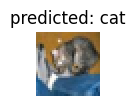

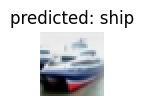

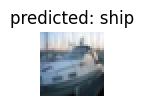

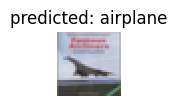

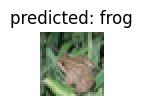

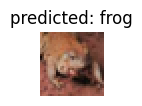

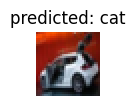

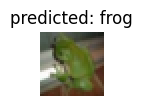

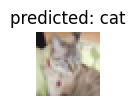

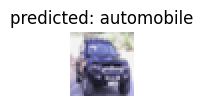

In [20]:
model.load_state_dict(model.state_dict())
visualize_model(model)

In [24]:

class_names = train_dataset.classes

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    # plt.savefig('/')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



def visualize_model(model, test_loader=test_loader, class_names=class_names, num_images=9):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far < num_images:
                    row = images_so_far // 3
                    col = images_so_far % 3
                    axs[row, col].imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
                    axs[row, col].axis('off')
                    axs[row, col].set_title('predicted: {}'.format(class_names[preds[j]]))
                    plt.savefig('./result.png')
                images_so_far += 1

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

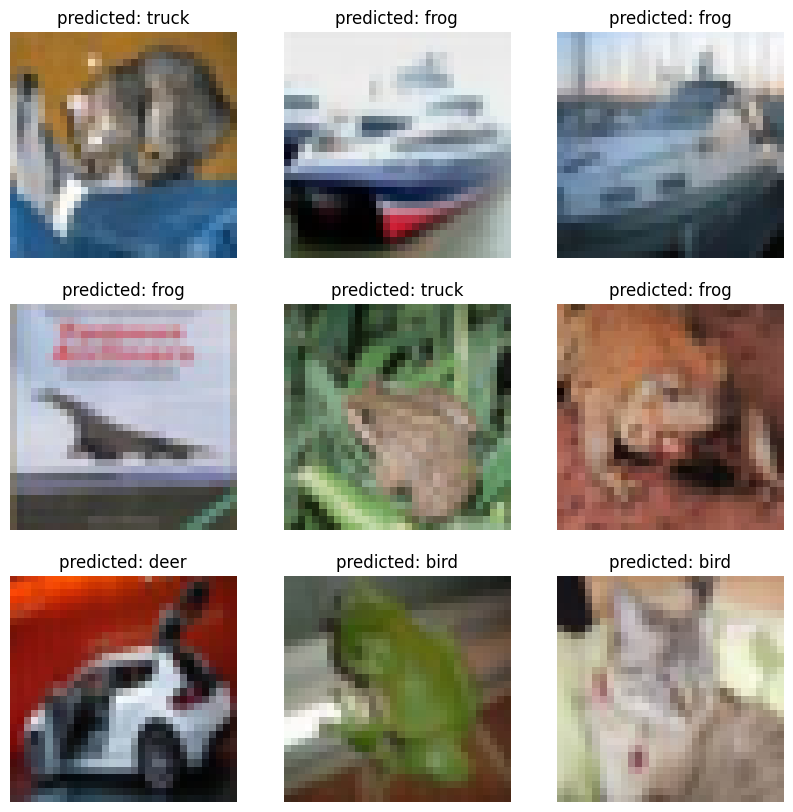

In [25]:
model.load_state_dict(model.state_dict())
visualize_model(model)